In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from IPython.display import SVG

открываем датасет:

In [139]:
df=pd.read_csv("train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Перед просмотром что-там по зависимостям параметров добавим в DF время,ибо это важно,во сколько брали велик,дату сразу дропаем-она ничего не значит:

Месяц не берём т.к. он будет коррелировать от сезона,так что только помешает

In [140]:
df['datetime']=pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['year']=df['datetime'].dt.year
df.drop(['datetime'],axis=1,inplace=True)

Сперва глянем кореляцию и исключим слишком карелирующий с ответом:

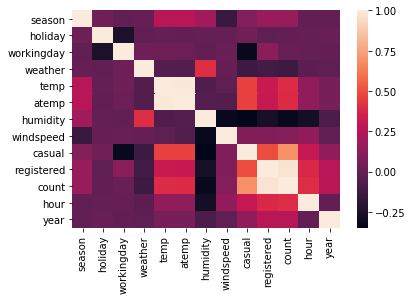

In [141]:
sns.heatmap(df.corr())

temp-atemp-надо дропать что-то,registered-casuas сразу дропаем так как сильно карелирую с counts:

In [142]:
df.drop(['registered','casual'],axis=True,inplace=True)

Хочу попробовать отобрать признаки,базируемся на основе важности,берем DecisionTreeRegressor и глянем,что он скажет по важности параметров:

In [143]:
Y=df['count']
X=df.drop(['count'],axis=1)
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X.values,Y.values,test_size=0.2)

In [144]:
model = DecisionTreeRegressor()
model.fit(Xtrain, Ytrain)
score=model.feature_importances_
for i in range (len(list(X))):
    print(list(X)[i],score[i])

season 0.06029582196212385
holiday 0.0029608893990805837
workingday 0.06693189017942477
weather 0.017478597793350033
temp 0.06388221037942123
atemp 0.030850297682058114
humidity 0.03096358727255252
windspeed 0.013991511901855042
hour 0.6210857709373621
year 0.0915594224927718


Так ну что же,похоже на holiday и weather (в силу кореляции пар-ра с humidity) можно забить сразу и дропнуть их заранее:

In [145]:
df.drop(['holiday','weather'],axis=1,inplace=True)

Взглянем на корреляцию еще разок:

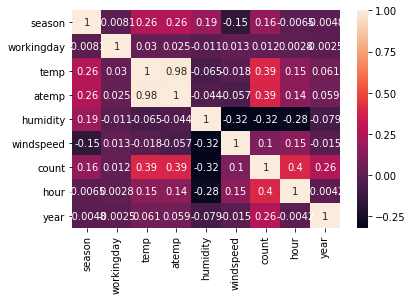

In [146]:
sns.heatmap(df.corr(),annot=True)

temp и atemp (дропнем atemp потому что всё-таки отбор важности сказал,что он чуть-чуть,но важнее):

In [147]:
df.drop(['atemp'],axis=True,inplace=True)

И еще раз смотрим:

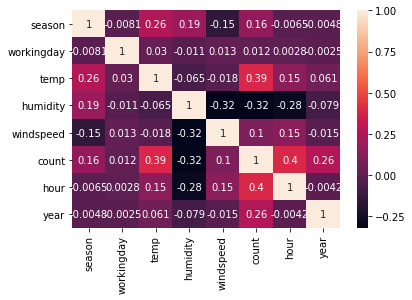

In [148]:
sns.heatmap(df.corr(),annot=True)

Ну вот теперь прямо всё по заданию,еще раз глянем на данные

In [149]:
df.head()

,season,workingday,temp,humidity,windspeed,count,hour,year
0,1,0,9.84,81,0.0,16,0,2011
1,1,0,9.02,80,0.0,40,1,2011
2,1,0,9.02,80,0.0,32,2,2011
3,1,0,9.84,75,0.0,13,3,2011
4,1,0,9.84,75,0.0,1,4,2011


Начинаем мучать модельку

Сперва нормализуем карелирющие с искомой величиной пар-ры:

 А нафиг? 

 Одно из допущений при работе с моделями,параметры которых оцениваются методом наименьших квадратов-остатки модели независыми т.е.не коррелируют и имеют нормальное распределение со средним значеним 0 и некоторым фикс. стандартным отклонением

In [150]:
scaler = StandardScaler()

In [151]:
scaler.fit_transform(df['temp'].values.reshape(-1, 1))
df['temp'] = scaler.transform(df['temp'].values.reshape(-1, 1))

In [152]:
scaler.fit_transform(df['hour'].values.reshape(-1, 1))
df['hour'] = scaler.transform(df['hour'].values.reshape(-1, 1))

/home/gleb/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gleb/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gleb/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [153]:
df.head()

,season,workingday,temp,humidity,windspeed,count,hour,year
0,1,0,-1.333661,81,0.0,16,-1.668944,2011
1,1,0,-1.438907,80,0.0,40,-1.524341,2011
2,1,0,-1.438907,80,0.0,32,-1.379739,2011
3,1,0,-1.333661,75,0.0,13,-1.235137,2011
4,1,0,-1.333661,75,0.0,1,-1.090534,2011


In [154]:
Y=df['count']
X=df.drop(['count'],axis=1)

Поставим максимальную глубину конечным фиксированным числом,а то без нее ноут умер при отрисовке дерева из svg:

Используем MSE т.к. отрицательные значения не компенсируют положительными и усиливается влияние ошибок, по квадратуре от исходного значения:

и что?

В сравнении с MAE:

1) Подчеркивает большие ошибки над меньшими

2)является дифференцируемой, что позволяет более эффективно использовать для поиска минимальных или максимальных значений с помощью математических методов

In [155]:
tree = DecisionTreeRegressor(max_depth=6,criterion='mse')

In [156]:
x_train, x_val, y_train, y_val = train_test_split(X.values, Y.values, test_size=0.2)

In [157]:
tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [158]:
export_graphviz(tree,out_file='tree.dot',feature_names=X.columns, filled=True) 

In [159]:
!dot -Tsvg tree.dot -o tree.svg

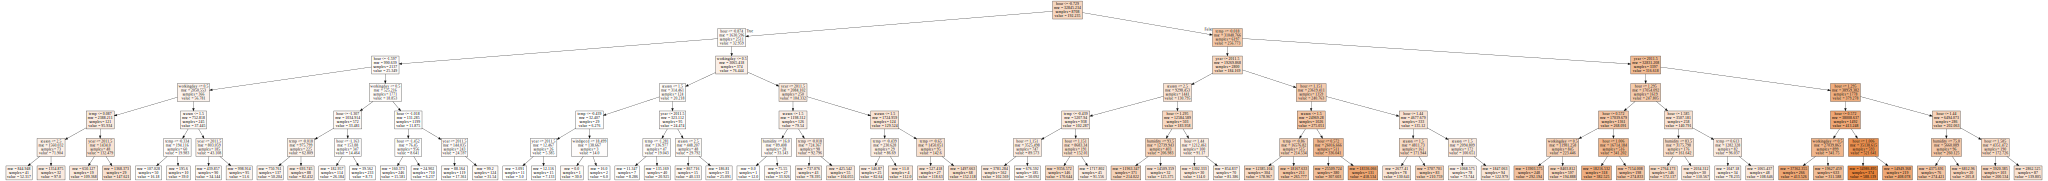

In [160]:
display(SVG('tree.svg'))

In [161]:
r2_score(y_val, tree.predict(x_val))

0.6783089206516565

Как фигово из коробки-то,пора прокачивать параметры другой коробкой:

In [162]:
tree_params = {'max_depth': range(1,15),'max_features': range(1,7),'min_samples_leaf':range(1,20)}

In [163]:
tree_grid= GridSearchCV(tree, tree_params,n_jobs=-1)

In [164]:
tree_grid.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(1, 7), 'min_samples_leaf': range(1, 20), 'max_depth': range(1, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [165]:
tree_grid.best_params_

{'max_depth': 13, 'max_features': 6, 'min_samples_leaf': 6}

In [182]:
tree_grid.best_score_

0.8899192752318166

In [183]:
tree = DecisionTreeRegressor(max_depth= 13, max_features=6, min_samples_leaf= 6)

In [184]:
tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=6,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [185]:
export_graphviz(tree,out_file='tree_fix.dot',feature_names=X.columns, filled=True) 

In [186]:
!dot -Tsvg tree_fix.dot -o tree_fix.svg

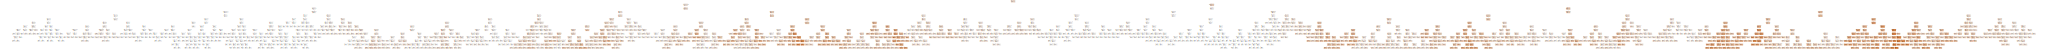

In [187]:
display(SVG('tree_fix.svg'))

Ну в целом не плохо,под 90% без сильно коррелирующих данных,но хотелось бы по-лучше,покрутим данные с  дерева:

попробуем покрутить опции пруннинга дерева,возьмём уже найденное оптимальное и попробуем улучшить:

In [188]:
tree = DecisionTreeRegressor(max_depth=12, max_features= 6, min_samples_leaf= 4)

In [189]:
prunning={'min_impurity_decrease': range(0,50)}

In [190]:
tree_prun_grid=GridSearchCV(tree, prunning)

In [191]:
tree_prun_grid.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=6,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_impurity_decrease': range(0, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [192]:
tree_prun_grid.best_params_

{'min_impurity_decrease': 1}

In [193]:
tree_prun_grid.best_score_

0.8864825701045946

**Лучше не стало,даже чутка хуже**

A что если попробовать подобрать все параметры заново,с учётом того,что добавим прунинг? 

Главное,чтобы ноут не умер в этом героическом сражении

In [194]:
tree = DecisionTreeRegressor()

In [195]:
tree_params= {'max_depth': range(1,15),'max_features': range(1,7),'min_samples_leaf':range(1,20),'min_impurity_decrease': range(1,15)}

In [196]:
tree_with_prun=GridSearchCV(tree, tree_params,n_jobs=-1)

Сейчас будут очень долгие вычисления:

In [197]:
tree_with_prun.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(1, 7), 'min_impurity_decrease': range(1, 15), 'min_samples_leaf': range(1, 20), 'max_depth': range(1, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [198]:
tree_with_prun.best_params_

{'max_depth': 12,
 'max_features': 6,
 'min_impurity_decrease': 3,
 'min_samples_leaf': 7}

In [199]:
tree_with_prun.best_score_

0.8892565235227726

In [200]:
tree = DecisionTreeRegressor(max_depth= 12,max_features=6,min_impurity_decrease=3,min_samples_leaf=7)

In [201]:
tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=6,
           max_leaf_nodes=None, min_impurity_decrease=3,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Результат стал лучше на одну тысячную и все,что после 3 знака,по сравнению с прокачкой гиперпараметров без прунинга

Но max_depth значитеьно увеличился,а это так себе можно нарваться на переобучение

**В общем когда-то и Нетфликс платил миллион за процент,так что неплохо**

In [202]:
export_graphviz(tree,out_file='tree_with_prun.dot',feature_names=X.columns, filled=True) 

In [203]:
!dot -Tsvg tree_with_prun.dot -o tree_with_prun.svg

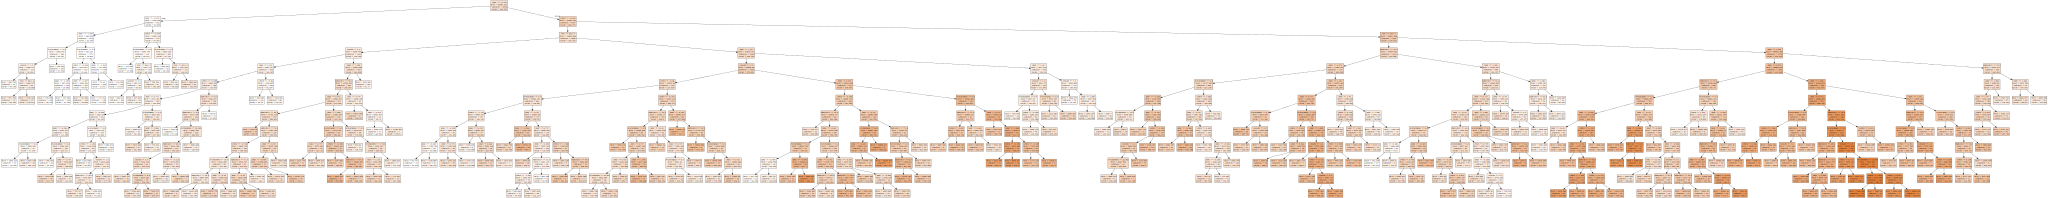

In [204]:
display(SVG('tree_with_prun.svg'))

Ну в целом,всё осталось так же,видимо выжал все,что можно-под 90% точности предсказания